In [6]:
import sys
sys.path.append("../../")
from django.conf import settings


import itertools
import operator
import django
import pylab as pl
import re

from django.contrib.gis.measure import D

from django.db import connections
from firecares.firestation.models import FireDepartment, FireStation
from firecares.utils import dictfetchall
from pandas import DataFrame

%matplotlib inline

django.setup()

def hamming(str1,str2):
    ne = operator.ne
    return sum(itertools.imap(ne,str1,str2))

stations = FireStation.objects.filter(department__isnull=True, state='VA')

print "Number of unmatched fire stations:", stations.count()

cursor = connections['default'].cursor()


unmatched_stations_with_geom = stations.filter(geom__isnull=False)


print 'Unmatched Stations with Geometry:', unmatched_stations_with_geom.count()


totalMatchedDepartments = 0
totalFalseMatches = 0
matchedDict = dict()
debugLog = True


for fireStation in unmatched_stations_with_geom:
    
    title = "# Searching for departmens for Station: {0} #".format(fireStation.name)
    
    print '#' * len(title)
    print title
    #print '#' * len(title)
    
    

    
    alwaysRemoved = { "Station": "", 
            " Engine": "",
            " Truck": "",
            " Ladder": "",
            " Quint": "",
            " Squirt": "",
            " Ambulance": "",
            " Service": "",
            " District": "",
            " Headquarters" : "",
            " City" : "",
            } 
    levRemoved = { 
            " Rescue": "",
            " Service": "",
            " and": "",
            " Emergency": "",
            " Medical": "",
            " Services": "",
            } 
    alwaysRemoved = dict((re.escape(k), v) for k, v in alwaysRemoved.iteritems())
    levRemoved = dict((re.escape(k), v) for k, v in levRemoved.iteritems())
    alwaysPattern = re.compile("|".join(alwaysRemoved.keys()))
    pattern = re.compile("|".join(levRemoved.keys()))
    fireStation.name = alwaysPattern.sub(lambda m: alwaysRemoved[re.escape(m.group(0))], fireStation.name)
    fireStation.name = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", fireStation.name)
    fireStation.name =  re.sub(' +',' ', fireStation.name)
    fireStation.name = fireStation.name.strip()
    stationName = fireStation.name
    stationName = pattern.sub(lambda m: levRemoved[re.escape(m.group(0))], stationName)
    stationName = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", stationName)
    stationName =  re.sub(' +',' ', stationName)
    stationName = stationName.strip()
    
    meterStation = fireStation.geom.transform(3857,True)
    # This should be close to the queryNearbyDepartments query
    nearby_departments = FireDepartment.objects.filter(headquarters_address__geom__distance_lte=(meterStation, D(mi=40)))\
    .transform(3857)\
    .distance(meterStation)\
    .extra(select={'dis_name': "select levenshtein(firestation_firedepartment.name, %s)", 'dis_sound': "select similarity(firestation_firedepartment.name, %s)"}, select_params=(stationName,fireStation.name))\
    .order_by('distance', '-dis_sound')

    distanceRatio = 0
    closestDepID = 0
    closestDepName = ''
    if not nearby_departments:
        continue

    maxDepartmentScore = list()
    #print 'Nearby Department Count: {0}'.format(nearby_departments.count())
    for n, fireDepartment in enumerate(nearby_departments):
        
        if n == 50:
            break
        departmentDistance = 40
        departmentJurisdiction = 50
        exactName = False

        if fireDepartment.distance is not None:
            departmentDistance = fireDepartment.distance.mi
        else:
            meterDepartment = fireDepartment.headquarters_address.geom.transform(3857,True)
            departmentDistance = meterDepartment.distance(meterStation) * 0.000621371 
        
       
        #if there is a exact match in name more than likely this is the department
        if fireDepartment.name == stationName:
            closestDepID = fireDepartment.id
            closestDepName = fireDepartment.name
            exactName = True
            break
            
        #The maximum return from levenshtein will be the length of the longer string
        # so to create a true 0-1 ratio find the longer string name
        minName = min(len(stationName),len(fireDepartment.name))
        longestName = max(len(stationName),len(fireDepartment.name))
        minDistance = longestName - minName
        
        #if the strings are the same length then the hamming distance is the upperbound
        #if minName == longestName:
            #longestName = hamming(stationName,fireDepartment.name)
            #if(longestName == 0):
                #longestName = minName
        
        #lower bound of levenshtein is at least difference of strings
        #to create zero to one ratio must subtract minimum distances
        fireDepartment.dis_name = max(fireDepartment.dis_name - minDistance,0)
        
        departmentRatio = ((1 - departmentDistance / 40) * 50) + (1 - fireDepartment.dis_name / longestName) * 90 #+ (fireDepartment.dis_sound * 25)
        
 
        if departmentRatio >= 140:
            closestDepID = fireDepartment.id
            closestDepName = fireDepartment.name
            fireDepartment.distance = departmentDistance
            maxDepartmentScore.append(fireDepartment)
        #print 'comparing firestation {0} to firedepartment {1}'.format(stationName, fireDepartment.name)
        #print 'department distance: {0} mi'.format(departmentDistance)
        #print 'department name distance: {0}'.format(fireDepartment.dis_name / longestName)
        #print 'department name similarity: {0}'.format(fireDepartment.dis_sound)
        #print 'distance ratio: {0}, department ratio: {1}'.format(distanceRatio, departmentRatio)

        if departmentRatio > distanceRatio:
            distanceRatio = departmentRatio
            smallestDistance = departmentDistance
            smallestNameDistance = fireDepartment.dis_name
            closestDepID = fireDepartment.id
            closestDepName = fireDepartment.name
        
        #print

    #fireStation.department_id = closestDepID
    
    if len(maxDepartmentScore) > 1 and exactName == False:
        smallestNameDistance = 0
        for maxDepartment in maxDepartmentScore:
            if maxDepartment.dis_sound > smallestNameDistance:
                closestDepID = maxDepartment.id
                closestDepName = maxDepartment.name
                smallestNameDistance = maxDepartment.dis_sound
    
    matchedDict[closestDepName] = matchedDict.get(closestDepName, 0) + 1
    #print '#' * len(title)        
    print 'Matched with: {0}'.format(closestDepName)

    if closestDepID == fireStation.department_id:
        totalMatchedDepartments += 1
        print 'Correctly Matched Department'
    elif fireStation.department_id:
        totalFalseMatches += 1
        correctDepartment = FireDepartment.objects.filter(id=fireStation.department_id)\
        .extra(select={'dis_name': "select levenshtein(firestation_firedepartment.name, %s)", 'dis_sound': "select similarity(firestation_firedepartment.name, %s)"}, select_params=(stationName,fireStation.name))[0]
        falseDepartment = FireDepartment.objects.filter(id=closestDepID)\
        .extra(select={'dis_name': "select levenshtein(firestation_firedepartment.name, %s)", 'dis_sound': "select similarity(firestation_firedepartment.name, %s)"}, select_params=(stationName,fireStation.name))\
        .get(id=closestDepID)
        correctGeom = correctDepartment.headquarters_address.geom.transform(3857,True)
        falseGeom = falseDepartment.headquarters_address.geom.transform(3857,True)
        print 'Firestation location is {0}'.format(meterStation)
        print 'Correct Department is {0}'.format(correctDepartment.name)
        print 'Correct Department location is {0}'.format(correctGeom)
        print 'Distance from station is {0}'.format(meterStation.distance(correctGeom) * 0.000621371)
        print 'Name Distance is {0}'.format(correctDepartment.dis_name)
        print 'Name Similarity is {0}'.format(correctDepartment.dis_sound)
        print '#' * len(title)
        print 'False Match Department is {0}'.format(falseDepartment.name)
        print 'False Department Location is {0}'.format(falseGeom)
        print 'Distance from station is {0}'.format(meterStation.distance(falseGeom) * 0.000621371)
        print 'Name Distance is {0}'.format(falseDepartment.dis_name)
        print 'Name Similarity is {0}'.format(falseDepartment.dis_sound)
    #print 'matched:', matchedDict
    #print "#############################################"
    #print
    #print
    

print 'Correctly Matched Department Count: {0}'.format(totalMatchedDepartments)
print 'Incorrectly Matched Department Count: {0}'.format(totalFalseMatches)

#cursor.execute(queryQualityControl)
#qualityControl = dictfetchall(cursor)

#totalStationMatches = 0
#totalIncorrectStations = 0
#for fireDepartment in qualityControl:
    #if matchedDict.get(fireDepartment['fd_name']) != None:
       # if matchedDict[fireDepartment['fd_name']] == fireDepartment['num_stations']:
        #    totalStationMatches += 1
        #else:
         #   totalIncorrectStations += 1        
#print "Station Matches:", totalStationMatches
#print "Incorrect Station Counts:", totalIncorrectStations
     

Number of unmatched fire stations: 125
Unmatched Stations with Geometry: 125
#################################################################################
# Searching for departmens for Station: Green Springs Volunteer Fire Department #
Matched with: Abingdon Volunteer Fire Department
#########################################################################################
# Searching for departmens for Station: Virginia Department of Forestry Accomack County #
Matched with: Tasley Volunteer Fire Company
###########################################################################
# Searching for departmens for Station: Amherst Volunteer Fire Department #
Matched with: Monelison Volunteer Fire Department
###########################################################################
# Searching for departmens for Station: Arvonia Volunteer Fire Department #
Matched with: Fork Union Volunteer Fire Company
#########################################################################
# Searchin

In [4]:
import sys
sys.path.append("../../")

import itertools
import operator
import django
import pylab as pl
import re

from django.contrib.gis.measure import D

from django.db import connections
from firecares.firestation.models import FireDepartment, FireStation
from firecares.usgs.models import CountyorEquivalent
from firecares.utils import dictfetchall
from pandas import DataFrame

%matplotlib inline

django.setup()

def hamming(str1,str2):
    ne = operator.ne
    return sum(itertools.imap(ne,str1,str2))

def determineCountyName(name):
    nameWordList = name.split()
    stationCounty = None
    matchVolunteer = re.search(r'\bVolunteer\b',name)
    matchCounty = re.search(r'\bCounty\b',name)
    if matchCounty is not None and matchVolunteer is None:
        stationCounty = nameWordList[nameWordList.index('County') - 1]
    elif matchCounty is None and matchVolunteer is not None:
        stationCounty = nameWordList[nameWordList.index('Volunteer') - 1]
    elif matchCounty is not None and matchVolunteer is not None:
        stationCounty = nameWordList[nameWordList.index('Volunteer') - 1]
        
    return stationCounty
        

# FireStation ids with wrong matches
wrong = [11100, 32447, 53489, 30674, 11490,53548, 53593, 80103, 45243, 11080,11702,53289,45550,53343,53668,51229,24841,53159,11242,53432,35921,53331,42918,
        33178,51457, 53253, 53386, 16510, 53427, 53220, 49984, 50029, 53539,53222,  27740, 24770, 11109, 11735, 53208,53574,
         53595, 53166, 53492, 53272, 39444, 53550, 24772, 42888, 41459, 53469, 53664, 17557, 53234, 14708,53279,53316,
         53478, 11778, 41978, 29847, 27208, 50942, 48421,46516, 53452,41742, 14148, 2706, 30345, 53418, 52561, 53365, 
         43322, 49392, 53221, 26790, 35909, 19882, 30859, 22078, 50929, 2690, 29848, 41454,26426, 53357, 53500, 53444,
         53537, 53408, 53441, 53164, 53562, 31652, 45500, 25346, 37553, 27439, 53654, 53379, 899, 13504, 53342, 53362, 
         53710, 53257, 53308, 53591, 33524, 96830, 53196, 53223, 43131, 53236, 45608, 11134, 11759, 41152, 4273, 4271,
         22940, 17674, 42361, 15257, 50560, 1923, 2107, 23316, 11315, 53416, 30586, 44099, 16468,53413, 53419, 47204,53571,
         53517, 53225, 53479, 53160, 53683, 21995, 11150, 1834, 53282, 16798, 1847, 53430, 53735, 53506, 44365, 53501,
         30931, 97072, 11088, 53353, 53353, 27269, 53168, 36092, 21697, 31038, 38162, 27165, 32411, 10385, 45223,
         53679, 53198, 53542, 11057, 4274, 53614, 53693, 53161, 50186, 2711, 16754, 53598, 53431, 53590
        ]

stations = FireStation.objects.filter( state='VA')

print "Number of unmatched fire stations:", stations.count()

cursor = connections['default'].cursor()


unmatched_stations_with_geom = stations.filter(geom__isnull=False)


print 'Unmatched Stations with Geometry:', unmatched_stations_with_geom.count()

totalMatchedDepartments = 0
totalFalseMatches = 0
matchedDict = dict()

updates = []

for fireStation in unmatched_stations_with_geom:
    
    title = "# Searching for departments for Station: {0}, id: {1}#".format(fireStation.name, fireStation.id)
    
    print '#' * len(title)
    print title
    #print '#' * len(title)
    

    alwaysRemoved = { "Station": "", 
            " Engine": "",
            " Truck": "",
            " Ladder": "",
            " Quint": "",
            " Squirt": "",
            " Ambulance": "",
            " Service": "",
            " District": "",
            " Headquarters" : "",
            " City" : "",
            } 
    levRemoved = { 
            " Rescue": "",
            " Service": "",
            " and": "",
            " Emergency": "",
            " Medical": "",
            " Services": "",
            } 
    alwaysRemoved = dict((re.escape(k), v) for k, v in alwaysRemoved.iteritems())
    levRemoved = dict((re.escape(k), v) for k, v in levRemoved.iteritems())
    alwaysPattern = re.compile("|".join(alwaysRemoved.keys()))
    pattern = re.compile("|".join(levRemoved.keys()))
    fireStation.name = alwaysPattern.sub(lambda m: alwaysRemoved[re.escape(m.group(0))], fireStation.name)
    fireStation.name = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", fireStation.name)
    fireStation.name =  re.sub(' +',' ', fireStation.name)
    fireStation.name = fireStation.name.strip()
    stationName = fireStation.name
    stationName = pattern.sub(lambda m: levRemoved[re.escape(m.group(0))], stationName)
    stationName = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", stationName)
    stationName =  re.sub(' +',' ', stationName)
    stationName = stationName.strip()

    
    # This should be close to the queryNearbyDepartments query
    nearby_departments = FireDepartment.objects.filter(headquarters_address__geom__distance_lte=(fireStation.geom, D(mi=40)))\
    .distance(fireStation.geom)\
    .extra(select={'dis_name': "select levenshtein(firestation_firedepartment.name, %s)", 'dis_sound': "select similarity(firestation_firedepartment.name, %s)"}, select_params=(stationName,fireStation.name,))\
    .order_by('distance','dis_name')

    distanceRatio = 0
    closestDepID = 0
    closestDepName = ''
    if not nearby_departments:
        continue

    meterStation = fireStation.geom.transform(3857,True)
    stationCounty = CountyorEquivalent.objects.get(geom__intersects=(fireStation.geom))
    maxDepartmentScore = list()
    #print 'Nearby Department Count: {0}'.format(nearby_departments.count())
    for n, fireDepartment in enumerate(nearby_departments):
        
        if n == 100:
            break
        departmentDistance = 40
        countyScore = 0
        exactName = False

        #typically volunteer station doesnt match a volunteer department
        #matchVolunteer = re.search(r'\bVolunteer\b',stationName)
        #matchCounty = re.search(r'\bVolunteer\b',fireDepartment.name)
        #if matchVolunteer is not None and matchCounty is not None:
            #continue

            
        if fireDepartment.distance is not None:
            departmentDistance = fireDepartment.distance.mi
        else:
            meterDepartment = fireDepartment.headquarters_address.geom.transform(3857,True)
            departmentDistance = meterDepartment.distance(meterStation) * 0.000621371 
        

        departmentCounty = CountyorEquivalent.objects.filter(geom__dwithin=(fireDepartment.headquarters_address.geom,D(mi=20)))
        
        numCounties = len(departmentCounty)
        for nearbyCounty in departmentCounty:
            if stationCounty.name == nearbyCounty.name:
                #print 'County Match: {0}'.format(fireDepartment.name)
                countyScore = 25
            
        #The maximum return from levenshtein will be the length of the longer string
        # so to create a true 0-1 ratio find the longer string name
        minName = min(len(stationName),len(fireDepartment.name))
        longestName = max(len(stationName),len(fireDepartment.name))
        minDistance = longestName - minName
        
        #if the strings are the same length then the hamming distance is the upperbound
        #if minName == longestName:
            #longestName = hamming(stationName,fireDepartment.name)
            #if(longestName == 0):
                #longestName = minName
        
        #lower bound of levenshtein is at least difference of strings
        #to create zero to one ratio must subtract minimum distances
        fireDepartment.dis_name = max(fireDepartment.dis_name - minDistance,0)
        
        if(departmentDistance < 0.05 and fireDepartment.dis_name > 5 and fireDepartment.dis_sound < 0.89 and countyScore > 0):
            departmentDistance = 40
        
        departmentRatio = countyScore + ((1 - departmentDistance / 40) * 55) + (1 - fireDepartment.dis_name / longestName) * 80 + (fireDepartment.dis_sound * 30)
        
 
        if departmentRatio >= 190:
            closestDepID = fireDepartment.id
            closestDepName = fireDepartment.name
            fireDepartment.distance = departmentDistance
            maxDepartmentScore.append(fireDepartment)
        #print 'comparing firestation {0} to firedepartment {1}'.format(stationName, fireDepartment.name)
        #print 'department distance: {0} mi'.format(departmentDistance)
        #print 'department name distance: {0}'.format(fireDepartment.dis_name / longestName)
        #print 'department name similarity: {0}'.format(fireDepartment.dis_sound)
        #print 'distance ratio: {0}, department ratio: {1}'.format(distanceRatio, departmentRatio)

        if departmentRatio > distanceRatio:
            distanceRatio = departmentRatio
            smallestDistance = departmentDistance
            smallestNameDistance = fireDepartment.dis_name
            closestDepID = fireDepartment.id
            closestDepName = fireDepartment.name
        
        #print

    #fireStation.department_id = closestDepID
    
    if len(maxDepartmentScore) > 1 and exactName == False:
        smallestNameDistance = 0
        for maxDepartment in maxDepartmentScore:
            if maxDepartment.dis_sound > smallestNameDistance:
                closestDepID = maxDepartment.id
                closestDepName = maxDepartment.name
                smallestNameDistance = maxDepartment.dis_sound
    
    matchedDict[closestDepName] = matchedDict.get(closestDepName, 0) + 1
    
    if fireStation.id in wrong and not fireStation.department:
            print 'Incorrectly matched with: {0}, id: {1}'.format(closestDepName, closestDepID)

    #print '#' * len(title)        

    if closestDepID == fireStation.department_id:
        totalMatchedDepartments += 1
        #print 'Correctly Matched Department'
    elif fireStation.department_id:
        totalFalseMatches += 1
        correctDepartment = FireDepartment.objects.filter(id=fireStation.department_id)\
        .extra(select={'dis_name': "select levenshtein(firestation_firedepartment.name, %s)", 'dis_sound': "select similarity(firestation_firedepartment.name, %s)"}, select_params=(stationName,fireStation.name))\
        .get(id=fireStation.department_id)
        correctDepartmentCounty = CountyorEquivalent.objects.filter(geom__intersects=(correctDepartment.headquarters_address.geom))
        falseDepartment = FireDepartment.objects.filter(id=closestDepID)\
        .extra(select={'dis_name': "select levenshtein(firestation_firedepartment.name, %s)", 'dis_sound': "select similarity(firestation_firedepartment.name, %s)"}, select_params=(stationName,fireStation.name))\
        .get(id=closestDepID)
        correctGeom = correctDepartment.headquarters_address.geom.transform(3857,True)
        falseGeom = falseDepartment.headquarters_address.geom.transform(3857,True)
        print 'Firestation location is {0}'.format(meterStation)
        print 'Firestation county is {0}'.format(stationCounty.name)
        print 'Correct Department is {0}'.format(correctDepartment.name)
        print 'Correct Department location is {0}'.format(correctGeom)
        if len(correctDepartmentCounty) == 1:
            print 'Correct Department county is {0}'.format(correctDepartmentCounty[0].name)
        else:
            print 'Correct Department county is None'
            
        print 'Distance from station is {0}'.format(meterStation.distance(correctGeom) * 0.000621371)
        print 'Name Distance is {0}'.format(correctDepartment.dis_name)
        print 'Name Similarity is {0}'.format(correctDepartment.dis_sound)
        print '#' * len(title)
        print 'False Match Department is {0}'.format(falseDepartment.name)
        print 'False Department Location is {0}'.format(falseGeom)
        print 'Distance from station is {0}'.format(meterStation.distance(falseGeom) * 0.000621371)
        print 'Name Distance is {0}'.format(falseDepartment.dis_name)
        print 'Name Similarity is {0}'.format(falseDepartment.dis_sound)
    #print 'matched:', matchedDict
    #print "#############################################"
    #print
    #print
    

print 'Correctly Matched Department Count: {0}'.format(totalMatchedDepartments)
print 'Incorrectly Matched Department Count: {0}'.format(totalFalseMatches)


Number of unmatched fire stations: 1010
Unmatched Stations with Geometry: 1010
#######################################################################################
# Searching for departments for Station: Abingdon Volunteer Fire Department, id: 25852#


ValueError: Only numeric values of degree units are allowed on geographic DWithin queries.

Axes(0.125,0.125;0.775x0.775)
count    2668.000000
mean       13.319340
std        11.903844
min         0.000000
25%         4.000000
50%        12.000000
75%        17.000000
max        81.000000
Name: levenshtein, dtype: float64


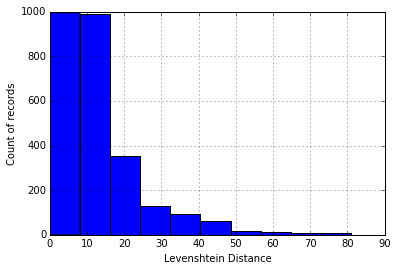

In [37]:
cursor = connections['default'].cursor()
query = """
select c.name as department_name, a.name as department_name, levenshtein(c.name, replace(a.name, 'Station', '')) 
from firestation_usgsstructuredata a 
inner join firestation_firestation b
  on a.id=b.usgsstructuredata_ptr_id 
join firestation_firedepartment c 
  on b.department_id=c.id;
"""
cursor.execute(query)
results = dictfetchall(cursor)
df = DataFrame(results)

# distribution of levenshtein distances
pl.xlabel("Levenshtein Distance")
pl.ylabel("Count of records")
print df['levenshtein'].hist()

print df['levenshtein'].describe()



In [ ]:
cursor = connections['default'].cursor()
query = """
select c.name as department_name, a.name as department_name, levenshtein(c.name, a.name) 
from firestation_usgsstructuredata a 
inner join firestation_firestation b
  on a.id=b.usgsstructuredata_ptr_id 
join firestation_firedepartment c 
  on b.department_id=c.id;
"""
cursor.execute(query)
results = dictfetchall(cursor)
df = DataFrame(results)
print df['levenshtein'].hist()
print df['levenshtein'].describe()


In [ ]:
### replace 'Station' and numeric characters
cursor = connections['default'].cursor()
query = """
select c.name as department_name, a.name as department_name, levenshtein(c.name, substring(replace(a.name, 'Station', '') from '^[a-zA-Z -]+')) 
from firestation_usgsstructuredata a 
inner join firestation_firestation b
  on a.id=b.usgsstructuredata_ptr_id 
join firestation_firedepartment c 
  on b.department_id=c.id;
"""
cursor.execute(query)
results = dictfetchall(cursor)
df = DataFrame(results)

# distribution of levenshtein distances
pl.xlabel("Levenshtein Distance")
pl.ylabel("Count of records")
print df['levenshtein'].hist()
print df['levenshtein'].describe()


In [ ]:
query = """
select c.name as department_name, a.name as department_name, levenshtein(c.name, a.name), ST_DISTANCE(ST_Transform(e.geom, 900913), ST_Transform(d.geom, 900913)) as dis 
from firestation_usgsstructuredata a 
inner join firestation_firestation b 
  on a.id=b.usgsstructuredata_ptr_id 
join firestation_firedepartment c 
  on b.department_id=c.id 
join firecares_core_address d 
  on b.station_address_id=d.id
join firecares_core_address e 
  on c.headquarters_address_id=e.id
where e.geom is not null and c.geom is not null;  
  ;
"""
cursor.execute(query)
results = dictfetchall(cursor)
df = DataFrame(results)

# distribution of levenshtein distances
pl.suptitle("Distribution of distance from headquarters address")
pl.xlabel("Distance from headquarters address")
pl.ylabel("Count of records")

# convert meters to miles.
df['dis_mi'] = df['dis'] * 0.000621371
print df['dis_mi'].hist()
print df['dis_mi'].describe()